# Behavioral Cloning

The aim of this project is to teach a deep neural network to drive a car (only the steering angle, for now) based on a camera picture of the environment. The network will be trained using data generated by an "expert" human driver. This project will be done in a driving simulator provided by Udacity

#### Note on the code included in this report
The code on this report is executable, and should result in the same results as the model.py and drive.py files attached with this report. It's almost identical, but I may have done some change here and there to make it in the order I wanted on this report or to add some output to show the internal process of some functions. The code I have used to generate the video in the end of this report is the one in model.py and drive.py

Please also note that I'm using Keras 2.x, the API as some small changes.

## Data exploration

Note: I am using data that I have generated myself in the simulator, not the data provided by Udacity. When generating this data, I have done a few laps on the training track in both direction, plus a serie of recovery maneuvers (done by stopping the recording, moving to the side of the track or to a position where the car is not align with the track, restarting the recording and putting the car back aligned and centered on the track)

First, here is a visualization of the data. The file 'driving_log.csv' contains the usefull information. (I have also added a header line to this file so that it's easy to read with pandas, and modified the filepaths from absolute to relative)

In [1]:
TRAINING_FOLDER = './data/'

import pandas as pd

data = pd.read_csv(TRAINING_FOLDER + 'driving_log.csv')
data.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2017_04_01_15_20_35_547.jpg,IMG/left_2017_04_01_15_20_35_547.jpg,IMG/right_2017_04_01_15_20_35_547.jpg,-0.329206,0.815272,0.0,15.55847
1,IMG/center_2017_04_01_15_20_35_625.jpg,IMG/left_2017_04_01_15_20_35_625.jpg,IMG/right_2017_04_01_15_20_35_625.jpg,-0.261162,0.756948,0.0,16.24937
2,IMG/center_2017_04_01_15_20_35_704.jpg,IMG/left_2017_04_01_15_20_35_704.jpg,IMG/right_2017_04_01_15_20_35_704.jpg,-0.173677,0.650022,0.0,16.81819
3,IMG/center_2017_04_01_15_20_35_791.jpg,IMG/left_2017_04_01_15_20_35_791.jpg,IMG/right_2017_04_01_15_20_35_791.jpg,-0.144515,0.543096,0.0,17.25924
4,IMG/center_2017_04_01_15_20_35_861.jpg,IMG/left_2017_04_01_15_20_35_861.jpg,IMG/right_2017_04_01_15_20_35_861.jpg,-0.134795,0.543096,0.0,17.64949


We see that the data contains three images (left/right/center), the speed of the car, the steering angle, the throttle and the brake. These data can be divided into two type of data, the input and output.

The input data, coming from sensors, are the following:
- the cameras images, and
- the vehicle speed

The output data are the command send to the actuator:
- the steering angle,
- the throttle command, and
- the brake command

In the case of this lab, we only need to control the steering angle, so we can disregard the throttle and brake commands. The current speed can also be discarded, as the steering angle to keep the car on the track should not depend on the speed as long as the car behave in a normal way (when there is no skidding, or over/understeering)

So for your problem, the input used to train the model will be the images, and the output the steering angle.

## General data information

Let's see how many data sample we have, if there is any missing information, and also do some data clean up.

In [2]:
# data cleaning: left and right image have a leading space in front of the file path. Need to be removed
data['left'] = data['left'].str.lstrip()
data['right'] = data['right'].str.lstrip()

# check if there is missing data
missing = sum(data.isnull().sum(axis=0))
if missing > 0:
    print('There are {} missing data'.format(missing))
else:
    print('There is no missing data')

There is no missing data


In [3]:
import re
from datetime import datetime

# length of data
nb_samples = len(data)
print('Number of measurement samples: {}'.format(nb_samples))

Number of measurement samples: 17509


## Image information

Let display some images and some information about them.

In [4]:
def img_path(index, side='center'):
    global TRAINING_FOLDER
    global data
    return '{}{}'.format(TRAINING_FOLDER, data[side][index])

import cv2

img = cv2.imread(img_path(0))
print('The image format is {}'.format(img.shape))

The image format is (160, 320, 3)


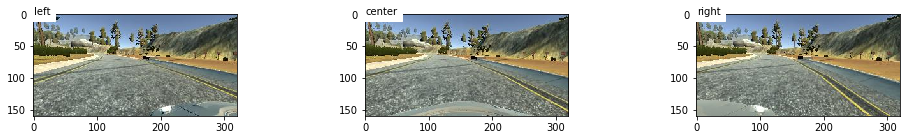

In [5]:
left_img = cv2.imread(img_path(0, 'left'))
center_img = cv2.imread(img_path(0))
right_img = cv2.imread(img_path(0, 'right'))

left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
center_img = cv2.cvtColor(center_img, cv2.COLOR_BGR2RGB)
right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14,2))
ax1 = fig.add_subplot(1,3, 1)
ax1.imshow(left_img)
plt.text(1,1,'left', color='k',backgroundcolor='w')

ax2 = fig.add_subplot(1,3, 2)
ax2.imshow(center_img)
plt.text(1,1,'center', color='k',backgroundcolor='w')

ax3 = fig.add_subplot(1,3, 3)
ax3.imshow(right_img)
plt.text(1,1,'right', color='k',backgroundcolor='w')

plt.tight_layout()


We see on these image that the bottom of the picture contains a part of the car. It may be necessary to remove the bottom to avoid learning specifically on this part if we use the three images, because if we use images from the three cameras at the same car place to learn, and if we add an offset to the left for the right image (and vice versa) the neural network may learn something like "if I see a part of the car on the right like in the left image, I need to turn to the right", which is undesirable. It's also possible to crop the top of the image, as the 60 top pixel lines shows only data from above the horizon, which is not usefull to drive in this simulation.

## Steering Angle Information

Let's look at the statistic of the steering angle.

In [6]:
import numpy as np

print('Mean steering angle: {:.2f}, Min steering angle: {:.2f}, Max steering angle: {:.2f}'
      .format(np.mean(data['steering']),
              np.min(data['steering']),
              np.max(data['steering'])))

Mean steering angle: -0.01, Min steering angle: -1.00, Max steering angle: 1.00


After this first look, it seems that the data is balanced, with a mean angle at 0 and a min and max aproximatively equal. Let's look at the angle distribution to check it more carefully

In [7]:
import bokeh

from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
from bokeh.charts import Histogram
output_notebook()

Loading BokehJS ...

In [8]:
p = Histogram(
           data, 'steering', bins=50, density=True,
           title="Steering angle distribution (percentage)")
show(p)


We see that the distribution of steering angle is largely dominated by very small steering angles. This is expected, as when we drive, most of the time we drive in a straight line with very small correction. We need to take this into account when generating the network training data. We need to keep some small angle data, but not keep that huge peak of data.

# Data augmentation

There are several methods that can be used to augment the data to increase the model robustness and at the same time improve the data distribution towards an uniform distribution for all angles.

I will use the following possibilities (the ideas about these come from the Udacity classrooms, slack and some medium articles):
- use left and right camera in addition to the center
- small image shift
- mirror the images horizontally
- shear the images to transform straight roads to curved roads
- image modification (example: changing brightness)

### Using left and right camera

The advantage of using the two other cameras is that we will get more 'recovery' data. As seen in the histogram above, the existing data is mainly data giving an angle steering of 0. By using the two other cameras, we will artificially add image where the action is to steer back to the ideal position. One of the problem of this method is that it introduce a new parameter to compute/evaluate, that is the offset to the target steering angle.

The effect of using these image on the dataset distribution is shown in the following histogram (with the offset angle currently set to 0.12, This parameter has been set by trial and error. As for other parameters below, they could be also learned by using a grid search or a random search and keeping the value that gives the best validation loss)

In [9]:
CAM_ANGLE_OFFSET = .12
steering_left_center_right = pd.concat([data['steering']-CAM_ANGLE_OFFSET, data['steering'], data['steering']+CAM_ANGLE_OFFSET])

p = Histogram(
           steering_left_center_right, density=True, bins=40,
           title="Steering angle distribution with left and right cam added")
show(p)

### Small translations

Small translations of the images will augment the dataset. I will use small vertical translation without changing the steering angle, and horizontal translation linked with a change in the steering angle proportional to the translation distance. This will have a similar effect that we would have if we had a lot of cameras along an horizontal axes (like the left, center and right cameras, but even more than that)

The proportionality factor between the horizontal translation and the steering angle change has been set by trial and error.

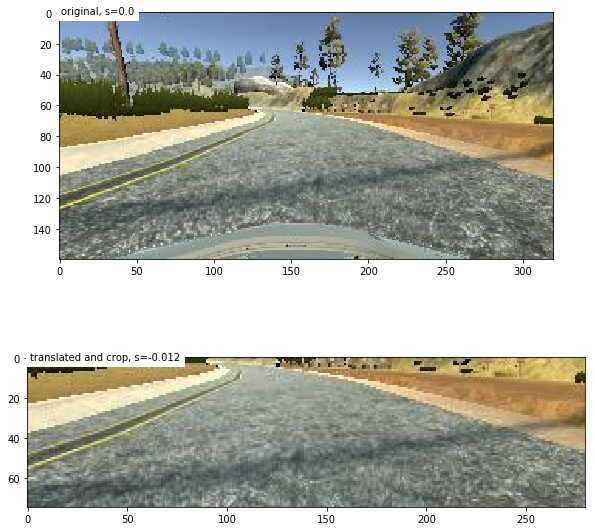

In [11]:
def translate_crop(img, steer, y_trans_max=2, x_trans_max=20, y_crop=(60,25), random=True, dx_dsteer=-.001):
    '''Translate image horizontally by a random number of pixel vertically and horizontally
    Crop the top, bottom, left and right part of the image'''
    
    # Compute the translation distance
    if random:
        dx = int(x_trans_max*(2*np.random.uniform()-1))
        dy = int(y_trans_max*(2*np.random.uniform()-1))
    else: # used for cropping the image for the validation part, without translation
        dx = 0
        dy = 0
        
    rows, cols, d = img.shape
    
    img = img[y_crop[0]:rows-y_crop[1], x_trans_max+dx:cols-x_trans_max+dx, :]
    steer += dx_dsteer * dx
    
    return img, steer

# display an example
idx = 20 # 0 steering example
steer = data['steering'][idx]
img = plt.imread(img_path(idx))
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,1, 1)
ax1.imshow(img)
plt.text(1,1,'original, s={}'.format(steer), color='k',backgroundcolor='w')

modified, new_steer=translate_crop(img, steer)
ax2 = fig.add_subplot(2,1, 2)
ax2.imshow(modified)
plt.text(1,1,'translated and crop, s={}'.format(new_steer), color='k',backgroundcolor='w')


### Mirror the images horizontally

By flipping horizontally the images (and changing the target angle sign) we symetricize the distribution of angles, which may fix a problem of the car wanting to turn more to the left or to the right, depending on the training data.

Note that this technic can be used here because the car is trying to stay on the road, and can drive in the middle, left or right. If we were looking at a car driving on public road, it cannot drive on the left side of the road (assuming right hand drive country) so it would not be good to use mirror images ;-)

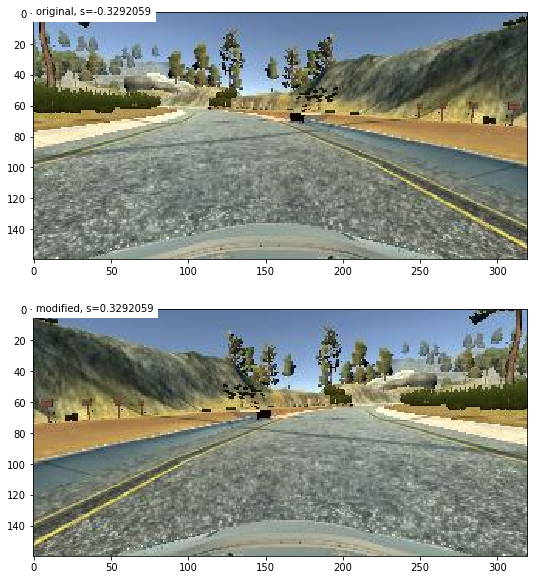

In [12]:
def flip(img, steer):
    '''Flip image vertically'''
    return cv2.flip(img, 1), -steer

# display an example
idx = 0 # non zero steering
steer = data['steering'][idx]
img = plt.imread(img_path(idx))
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,1, 1)
ax1.imshow(img)
plt.text(1,1,'original, s={}'.format(steer), color='k',backgroundcolor='w')

modified, new_steer=flip(img, steer)
ax2 = fig.add_subplot(2,1, 2)
ax2.imshow(modified)
plt.text(1,1,'modified, s={}'.format(new_steer), color='k',backgroundcolor='w')


### Image shearing
The idea of image shearing is to apply a affine transform to the image using OpenCV. The image center will be moved horizontaly to the left or to the right, while the bottom corner stay fixed. This would transform an image of a straight line to a curved road.

At the same time of this transformation, the steering angle will be transformed by adding a delta steering angle proportional to the horizontal movement of the center pixel. (again, this parameter has been fixed by trial and error, but could be learned using grid/random search and validation loss)

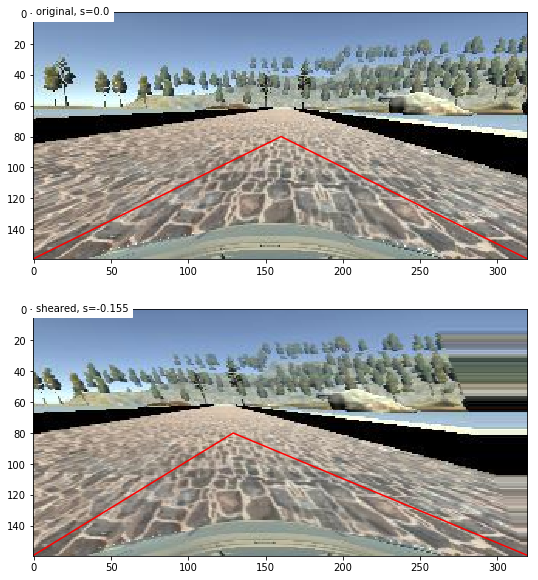

In [13]:
def shear(img,steer,shear_range=50, dshear_dsteer=.005, plot=False):
    rows,cols,d = img.shape
    
    # shear distance
    dshear = int(shear_range*(2*np.random.uniform()-1))
    new_center = [cols/2+dshear,rows/2]
    
    # source -> dest
    source = np.float32([[0,rows],[cols,rows],[cols/2,rows/2]])
    dest = np.float32([[0,rows],[cols,rows],new_center])
    
    dsteering = dshear * dshear_dsteer
    
    M = cv2.getAffineTransform(source,dest)
    img = cv2.warpAffine(img,M,(cols,rows),borderMode=1)
    steer +=dsteering
    
    if not plot:
        return img,steer
    else:
        return img, steer, new_center

# display an example
idx = 16420 # straight line
steer = data['steering'][idx]
img = plt.imread(img_path(idx))
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,1, 1)
ax1.imshow(img)
plt.text(1,1,'original, s={}'.format(steer), color='k',backgroundcolor='w')
plt.hold=True
rows, cols, d = img.shape
plt.plot([0,cols/2,cols-1], [rows-1, rows/2, rows-1], 'r')

modified, new_steer, new_center=shear(img, steer, plot=True, shear_range=100)

ax2 = fig.add_subplot(2,1, 2)
ax2.imshow(modified)
plt.text(1,1,'sheared, s={}'.format(new_steer), color='k',backgroundcolor='w')
plt.hold=True
plt.plot([0,new_center[0],cols-1], [rows-1, new_center[1], rows-1], 'r')

## Brightness

To improve robustness of the neural network to illumination conditions, and to augment the dataset, I use also a brightness transformation, increasing or decreasing the brightness of the image

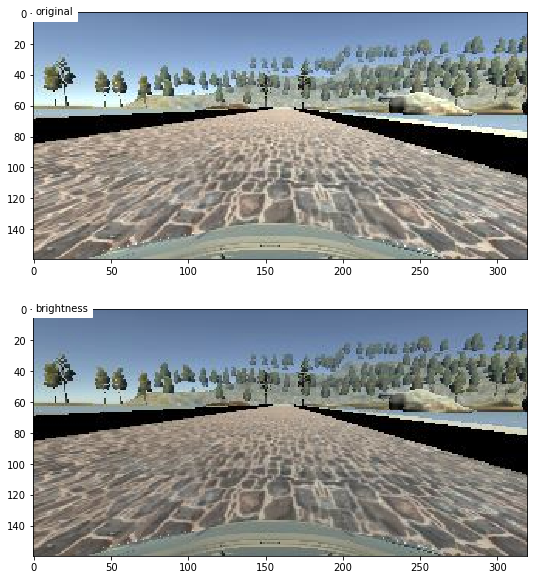

In [14]:
def brightness(img):
    '''Modify image brightness (between 50% and 150% of original image'''
    random_bright = .8 + .4*np.random.uniform()
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    img[:,:,2] = img[:,:,2]*random_bright
    img = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    
    return img

# display an example
idx = 16420 # straight line
img = cv2.imread(img_path(idx))
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,1, 1)
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.text(1,1,'original', color='k',backgroundcolor='w')

modified=brightness(img)

ax2 = fig.add_subplot(2,1, 2)
ax2.imshow(modified)
plt.text(1,1,'brightness', color='k',backgroundcolor='w')

### Putting it all together

Let's put all these step together in a data generator to be used later by Keras. I also add the possibility to use this generator without translation/shearing/brightness/... change, to be able to use the same generator to generated unmodified validation batches

In [19]:
def pre_process(img, nvidia_input_size=(200,66)):
    '''Resize image it to match desired neural net input
    Normalise between -1 and 1'''
    img = cv2.resize(img, nvidia_input_size, interpolation=cv2.INTER_AREA)
    return img/127.5 - 1.0

def augment_from_row(row, use_side_cam=False, offset=0.12):
    '''Read one of the three images from the given row, modify it with flip/translation/brightness change'''
    
    # select image and flip or not
    flip_it = np.random.choice([False, True])
    
    
    d_steering = 0
    if use_side_cam:
        side = np.random.choice(['center', 'left', 'right'])
        if side == 'left':
            d_steering += offset
        elif side == 'right':
            d_steering -= offset
    else:
        side = 'center'
    
    
    # read the image
    img = cv2.imread(row[side][0])
    steer = row['steering'][0] + d_steering
    
    if flip_it:
        img, steer = flip(img, steer)
        
    img, steer = shear(img, steer)

    img, steer = translate_crop(img, steer)
    
    img = brightness(img)
    
    return img, steer


def batch_generator(df, batch_size, augment=True, nvidia_input_size=(200,66)):
    '''Generate augmented image dataset'''
    X = np.zeros((batch_size, *nvidia_input_size, 3))
    y = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            idx = np.random.randint(len(df))
            if augment:
                row = df.iloc[[idx]].reset_index()
                img, steer = augment_from_row(row)
            else:   # for validation
                row = df.iloc[[idx]].reset_index()
                steer = row['steering'][0]
                if abs(steer) < .001:   # reduce the number of sample with a 0 steering angle
                    row = df.iloc[[idx]].reset_index()
                    steer = row['steering'][0]
                img = cv2.cvtColor(cv2.imread(row['center'][0]), cv2.COLOR_BGR2RGB)
                img,dummy = translate_crop(img, 0, random=False)
            X[i] = np.transpose(pre_process(img), axes=[1,0,2])
            y[i] = steer
        yield X,y
        

In [37]:
# mainly for test purpose, but can also show the angle distribution
df = data.copy()
df['left'] = TRAINING_FOLDER + '/' + df['left'].str.lstrip()
df['right'] = TRAINING_FOLDER + '/' + df['right'].str.lstrip()
df['center'] = TRAINING_FOLDER + '/' + df['center'].str.lstrip()

bg = batch_generator(df, batch_size=200, augment=True)
i = 0
steering = []
for X,y in bg:
    if i<20:
        i+=1
    else:
        break
    steering += list(y)

p = Histogram(
           steering, density=True, bins=40,
           title="Steering angle distribution after augmentation")
show(p)

We can see in the steering angle distribution after augmentation above that we now have a better angle distribution than before, without the major peak from the center camera alone or the three peaks from using the left, center and right images unaltered. The distribution has still a large over representation of smallish angles, but as you will see in the rest of this report, this distribution is good enough to get a good driving

## The neural network

This section will present the choices made for the neural network architecture and the justifications behind those choices. It will then continue with the training parameters used and the results of the training.

### Network architecture
I have started by using the same architecture as the one described in the [NVIDIA paper](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) on the same topics. I have added a few dropout layers to reduce overfitting.

Note that as this model is used for regression and not classification, there is no activation function on the final output.

In [42]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D

def nvidia_model(nvidia_input_size=(200, 66)):
    '''Generate Keras model for the network in the nvidia paper'''
    model = Sequential()
    
    model.add(Convolution2D(24, 5, input_shape=(*nvidia_input_size, 3), padding='valid', strides=(2, 2)))
    model.add(Activation('relu'))
    model.add(Dropout(.2))
    
    model.add(Convolution2D(36, 5, padding='valid', strides=(2, 2)))
    model.add(Activation('relu'))
    
    model.add(Convolution2D(48, 5, padding='valid', strides=(2, 2)))
    model.add(Activation('relu'))
    
    model.add(Convolution2D(64, 3, padding='valid'))
    model.add(Activation('relu'))
    
    model.add(Convolution2D(64, 3, padding='valid'))
    model.add(Activation('relu'))
    
    model.add(Flatten())
    
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(.3))
    
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(.3))
    
    model.add(Dense(50))
    model.add(Activation('relu'))
    
    model.add(Dense(10))
    model.add(Activation('relu'))
    
    model.add(Dense(1))
    
    return model

In [45]:
# Create the model
model = nvidia_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 98, 31, 24)        1824      
_________________________________________________________________
activation_28 (Activation)   (None, 98, 31, 24)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 98, 31, 24)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 47, 14, 36)        21636     
_________________________________________________________________
activation_29 (Activation)   (None, 47, 14, 36)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 22, 5, 48)         43248     
_________________________________________________________________
activation_30 (Activation)   (None, 22, 5, 48)         0         
__________

### Network training
The optimizer used for training the network is an Adam optimizer with default parameters.

To train the model, I use the generator created above for the training data, and the same generator, but passing the "augment=False" argument, which makes it use the original image without transformation other than cropping and resizing to the correct input size. These two generators are passed to the "fit_generator" function.

I also use two callback during the training (called after each epochs). The first one is there to save the model after each epoch (usefull for debugging purpose, or to test initial models while the model is still training, or if the training is interrupted by the user, ...)

The second callback is more important. It's an "EarlyStopping" callback, monitoring the validation loss and stopping the training when this loss stops to decrease. I have use the "patience" parameter of this callback to not stop after the first stop of decrease, to be sure that the current epoch was not a temporary increase. The use of this callback allows to put a large number of epochs, without having to find the good number of these epochs by trial and errors.

I use a batch size of 256 and 20 batchs per epochs, I've set the maximum epochs number to 100 but this will stop earlier due to the call back. The validation set at each epochs is 256x2 examples.

In [47]:
model.compile(optimizer='adam', loss='mse')

from keras.callbacks import ModelCheckpoint, EarlyStopping
# Early stopping callback
es = EarlyStopping(monitor='val_loss', patience=3)
# checkpoint saving
cp = ModelCheckpoint('./weights.{epoch:02d}-{val_loss:.6f}.hdf5', monitor='val_loss')

# train
model.fit_generator(
    batch_generator(df, batch_size=256),
    20, 100,
    callbacks=[es, cp],
    validation_data=batch_generator(df, batch_size=256, augment=False), validation_steps=2)

# save the final model
model.save('model.h5')

Epoch 1/100
20/20 [==============================] - 62s - loss: 0.0338 - val_loss: 0.0246

## Use the network to drive
Once we have trained the network, we need to use it to drive the car in the simulator. I use the drive.py given by Udacity, to which I have added some preprocessing on the camera images, which must be identical to the preprocessing done on the validation data. The pre_process function was called there:

    # The current image from the center camera of the car
    imgString = data["image"]
    image = Image.open(BytesIO(base64.b64decode(imgString)))
    image_array = np.asarray(image)
    
    # this line was added
    image_array = pre_process(image_array)
    steering_angle = float(model.predict(image_array[None, :, :, :], batch_size=1))

And the preprocess was defined as this, using the translate_crop with random=False (--> only crop)

    from model3 import translate_crop
    
    # and here is the pre_process function in drive.py
    nvidia_input_size = (66,200)
    def pre_process(img):
        '''Crop image and resize it to match desired neural net input,
        Normalise between -1 and +1'''
        img,dummy = translate_crop(img, 0, random=False)
        img = cv2.resize(img, nvidia_input_size[::-1], interpolation=cv2.INTER_AREA)
        img = np.transpose(img, axes=[1,0,2])
        return img/127.5-1.0

## Video results of the driving
Here is the result applied on the training track, with the speed controler set to 20mph. When running without the video recording (and at lower speed, like 15mph) the car doesn't go as close to the road edge as it does here at the end of the run, in the large curve.

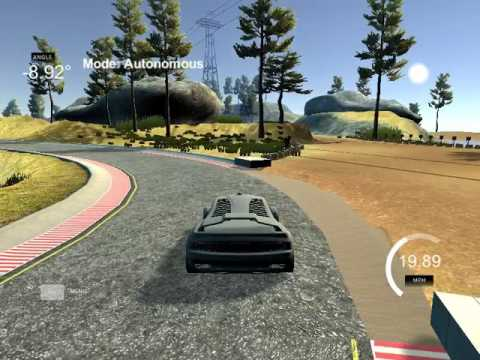

In [48]:
# We're done!
from IPython.display import YouTubeVideo
YouTubeVideo('S79DYYHmT-4')

## Acknowledgment

Part of the technics used in this project comes from the ideas discussed in the Udacity classroom, the slack channel, and from the NVIDIA paper [End to End Learning for Self-Driving Cars](https://images.nvidia.com/content/tegra/automotive/images/201
6/solutions/pdf/end-to-end-dl-using-px.pdf)